In [1]:
from tqdm.notebook import tqdm
import pandas
import numpy
import matplotlib.pyplot as plt

from ProblemInstance import ProblemInstance

from our_approach import leader_follower
from ablation_random_leader import al_random_leader
from ablation_no_duplication import al_no_duplication
from ablation_no_duplication import al_no_duplication_leader
from ablation_no_duplication import al_no_duplication_follower
from ablation_batch import al_batch_no_scale

In [2]:
def get_ops(problem, plan):
    return problem.operation_per_second(*problem.get_pc_packages_from_plan(*plan))

In [3]:
fontsize = 15
neurosim_dir = "NetStructure/"
summary_file = "NeuroSIMOut/summary.csv"

predef_N_X = numpy.array([
    12000, 400, 15600, 12000, 3600, 3600, 3600, 512, 90808, 
    15608, 15608, 15200, 1000, 1000, 1000, 1000, 1000, 1000,])

In [4]:
seed_set = numpy.arange(100)
n_req = 500
n_seed = 100

ops = numpy.zeros(6)

multi_model_problem = ProblemInstance(neurosim_dir)
multi_model_problem.read_nn_profile(summary_file)
nn_ids = numpy.arange(multi_model_problem.N_M)[:]

for seed in range(n_seed):
    nn = nn_ids[:]
    numpy.random.seed(seed)
    numpy.random.shuffle(nn)
    multi_model_problem.get_exact_requests(nn_ids=nn, n_x=predef_N_X[nn])

    plan_our = leader_follower(multi_model_problem)
    ops[0] += get_ops(multi_model_problem, plan_our)

    plan_random_leader = al_random_leader(multi_model_problem, seed=seed)
    ops[1] += get_ops(multi_model_problem, plan_random_leader)

    plan_no_duplication_leader = al_no_duplication_leader(multi_model_problem)
    ops[2] += get_ops(multi_model_problem, plan_no_duplication_leader)

    plan_no_duplication_follower = al_no_duplication_follower(multi_model_problem)
    ops[3] += get_ops(multi_model_problem, plan_no_duplication_follower)

    plan_no_duplication = al_no_duplication(multi_model_problem)
    ops[4] += get_ops(multi_model_problem, plan_no_duplication)

    plan_batch_one = al_batch_no_scale(multi_model_problem)
    ops[5] += get_ops(multi_model_problem, plan_batch_one)
ops /= n_seed

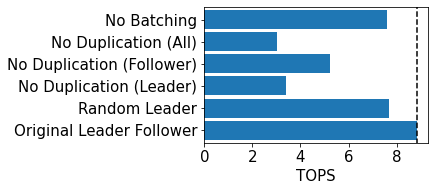

In [5]:
fontsize=15
plt.figure(figsize=(4, 2.5))
names = ["Original Leader Follower", "Random Leader", "No Duplication (Leader)", "No Duplication (Follower)", "No Duplication (All)", "No Batching"]
n_col = 1
width = 6
width_per_col = width/n_col
base_xticks = numpy.arange(len(names)) * (width+1)
plt.barh(base_xticks-width/2, ops, height=width_per_col, label="Intra")
plt.xticks(fontsize=fontsize)
plt.yticks(ticks=base_xticks-width_per_col/2, labels=names,rotation=0, fontsize=fontsize)
plt.vlines([ops[0]], -10, base_xticks[-1]+5, linestyles="dashed", color="black")
plt.ylabel("")
plt.xlabel("TOPS", fontsize=fontsize)
plt.ylim((-7, base_xticks[-1]+1))

plt.show()